## Hyperparameter

In [1]:
MNIST_SIZE = 28
HIDDEN_DIM = 400
LATENT_DIM = 50
BATCH_SIZE = 1000
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-6
SCHEDULER_STEP_SIZE = 50
SCHEDULER_GAMMA = 0.5

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [3]:
!pip install livelossplot

In [4]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.distributions as dists
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from livelossplot import PlotLosses
from prettytable import PrettyTable

## Binarized MNIST Dataset

In [5]:
class Binarized_MNIST(datasets.MNIST):
    def __init__(self, root, train, transform=None, target_transform=None, download=False):
        super(Binarized_MNIST, self).__init__(root, train, transform, target_transform, download)

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        return dists.Bernoulli(img).sample().type(torch.float32)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 488kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.0MB/s]


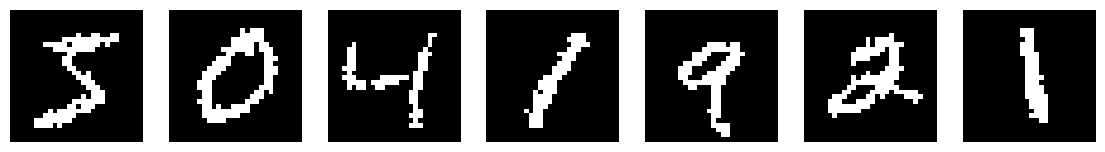

In [6]:
n_samples = 7
binarized_MNIST = Binarized_MNIST('./data', train=True, download=True,
                                  transform=transforms.ToTensor())
plt.figure(figsize=(14, 5))
for i in range(n_samples):
    plt.subplot(1, n_samples, 1 + i)
    plt.imshow(binarized_MNIST[i][0], vmin=0, vmax=1, cmap='gray')
    plt.axis('off')

## Model Implementation

In [7]:
class VAE(nn.Module):

    def __init__(self, k):
        super(VAE, self).__init__()
        self.k = k
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(MNIST_SIZE**2, HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, 2*LATENT_DIM)
        )
        self.decoder = nn.Sequential(
            nn.Linear(LATENT_DIM, HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, MNIST_SIZE**2),
            nn.Sigmoid()
        )
        return

    def compute_loss(self, x, k=None):
        if not k:
            k = self.k
        [x_tilde, z, mu_z, log_var_z] = self.forward(x, k)
        # upsample x
        x_s = x.unsqueeze(1).repeat(1, k, 1, 1, 1)
        # compute negative log-likelihood
        NLL = -dists.Bernoulli(x_tilde).log_prob(x_s).sum(axis=(2, 3, 4)).mean()
        # copmute kl divergence
        KL_Div = -0.5*(1 + log_var_z - mu_z.pow(2) - log_var_z.exp()).sum(1).mean()
        # compute loss
        loss = NLL + KL_Div
        return loss

    def forward(self, x, k=None):
        """feed image (x) through VAE

        Args:
            x (torch tensor): input [batch, img_channels, img_dim, img_dim]

        Returns:
            x_tilde (torch tensor): [batch, k, img_channels, img_dim, img_dim]
            z (torch tensor): latent space samples [batch, k, LATENT_DIM]
            mu_z (torch tensor): mean latent space [batch, LATENT_DIM]
            log_var_z (torch tensor): log var latent space [batch, LATENT_DIM]
        """
        if not k:
            k = self.k
        z, mu_z, log_var_z = self.encode(x, k)
        x_tilde = self.decode(z, k)
        return [x_tilde, z, mu_z, log_var_z]

    def encode(self, x, k):
        """computes the approximated posterior distribution parameters and
        samples from this distribution

        Args:
            x (torch tensor): input [batch, img_channels, img_dim, img_dim]

        Returns:
            z (torch tensor): latent space samples [batch, k, LATENT_DIM]
            mu_E (torch tensor): mean latent space [batch, LATENT_DIM]
            log_var_E (torch tensor): log var latent space [batch, LATENT_DIM]
        """
        # get encoder distribution parameters
        out_encoder = self.encoder(x)
        mu_E, log_var_E = torch.chunk(out_encoder, 2, dim=1)
        # increase shape for sampling [batch, samples, latent_dim]
        mu_E_ups = mu_E.unsqueeze(1).repeat(1, k, 1)
        log_var_E_ups = log_var_E.unsqueeze(1).repeat(1, k, 1)
        # sample noise variable for each batch and sample
        epsilon = torch.randn_like(log_var_E_ups)
        # get latent variable by reparametrization trick
        z = mu_E_ups + torch.exp(0.5*log_var_E_ups) * epsilon
        return z, mu_E, log_var_E

    def decode(self, z, k):
        """computes the Bernoulli mean of p(x|z)
        note that linear automatically parallelizes computation

        Args:
            z (torch tensor): latent space samples [batch, k, LATENT_DIM]

        Returns:
            x_tilde (torch tensor): [batch, k, img_channels, img_dim, img_dim]
        """
        # get decoder distribution parameters
        x_tilde = self.decoder(z)  # [batch*samples, MNIST_SIZE**2]
        # reshape into [batch, samples, 1, MNIST_SIZE, MNIST_SIZE] (input shape)
        x_tilde = x_tilde.view(-1, k, 1, MNIST_SIZE, MNIST_SIZE)
        return x_tilde

    def create_latent_traversal(self, image_batch, n_pert, pert_min_max=2, n_latents=5):
        device = image_batch.device
        # initialize images of latent traversal
        images = torch.zeros(n_latents, n_pert, *image_batch.shape[1::])
        # select the latent_dims with lowest variance (most informative)
        [x_tilde, z, mu_z, log_var_z] = self.forward(image_batch)
        i_lats = log_var_z.mean(axis=0).sort()[1][:n_latents]
        # sweep for latent traversal
        sweep = np.linspace(-pert_min_max, pert_min_max, n_pert)
        # take first image and encode
        [z, mu_E, log_var_E] = self.encode(image_batch[0:1], k=1)
        for latent_dim, i_lat in enumerate(i_lats):
            for pertubation_dim, z_replaced in enumerate(sweep):
                z_new = z.detach().clone()
                z_new[0][0][i_lat] = z_replaced

                img_rec = self.decode(z_new.to(device), k=1).squeeze(0)
                img_rec = img_rec[0].clamp(0, 1).cpu()

                images[latent_dim][pertubation_dim] = img_rec
        return images

    def compute_marginal_log_likelihood(self, x, k=None):
        """computes the marginal log-likelihood in which the sampling
        distribution is exchanged to q_{\phi} (z|x),
        this function can also be used for the IWAE loss computation

        Args:
            x (torch tensor): images [batch, img_channels, img_dim, img_dim]

        Returns:
            log_marginal_likelihood (torch tensor): scalar
            log_w (torch tensor): unnormalized log importance weights [batch, k]
        """
        if not k:
            k = self.k
        [x_tilde, z, mu_z, log_var_z] = self.forward(x, k)
        # upsample mu_z, std_z, x_s
        mu_z_s = mu_z.unsqueeze(1).repeat(1, k, 1)
        std_z_s = (0.5 * log_var_z).exp().unsqueeze(1).repeat(1, k, 1)
        x_s = x.unsqueeze(1).repeat(1, k, 1, 1, 1)
        # compute logarithmic unnormalized importance weights [batch, k]
        log_p_x_g_z = dists.Bernoulli(x_tilde).log_prob(x_s).sum(axis=(2, 3, 4))
        log_prior_z = dists.Normal(0, 1).log_prob(z).sum(2)
        log_q_z_g_x = dists.Normal(mu_z_s, std_z_s).log_prob(z).sum(2)
        log_w = log_p_x_g_z + log_prior_z - log_q_z_g_x
        # compute marginal log-likelihood
        log_marginal_likelihood = (torch.logsumexp(log_w, 1) -  np.log(k)).mean()
        return log_marginal_likelihood, log_w

<>:120: SyntaxWarning: invalid escape sequence '\p'
<>:120: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-3709176108.py:120: SyntaxWarning: invalid escape sequence '\p'
  distribution is exchanged to q_{\phi} (z|x),


In [8]:
class IWAE(VAE):

    def __init__(self, k):
        super(IWAE, self).__init__(k)
        return

    def compute_loss(self, x, k=None, mode='fast'):
        if not k:
            k = self.k
        # compute unnormalized importance weights in log_units
        log_likelihood, log_w = self.compute_marginal_log_likelihood(x, k)
        # loss computation (several ways possible)
        if mode == 'original':
            ####################### ORIGINAL IMPLEMENTAION #######################
            # numerical stability (found in original implementation)
            log_w_minus_max = log_w - log_w.max(1, keepdim=True)[0]
            # compute normalized importance weights (no gradient)
            w = log_w_minus_max.exp()
            w_tilde = (w / w.sum(axis=1, keepdim=True)).detach()
            # compute loss (negative IWAE objective)
            loss = -(w_tilde * log_w).sum(1).mean()
        elif mode == 'normalized weights':
            ######################## LOG-NORMALIZED TRICK ########################
            # copmute normalized importance weights (no gradient)
            log_w_tilde = log_w - torch.logsumexp(log_w, dim=1, keepdim=True)
            w_tilde = log_w_tilde.exp().detach()
            # compute loss (negative IWAE objective)
            loss = -(w_tilde * log_w).sum(1).mean()
        elif mode == 'fast':
            ########################## SIMPLE AND FAST ###########################
            loss = -log_likelihood
        return loss

## Training

In [9]:
def train(dataset, vae_model, iwae_model, num_epochs):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print('Device: {}'.format(device))

    data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True,
                             num_workers=12)
    vae_model.to(device)
    # iwae_model.to(device)

    optimizer_vae = torch.optim.Adam(vae_model.parameters(), lr=LEARNING_RATE,
                                     weight_decay=WEIGHT_DECAY)
    # optimizer_iwae = torch.optim.Adam(iwae_model.parameters(), lr=LEARNING_RATE,
    #                                  weight_decay=WEIGHT_DECAY)
    scheduler_vae = torch.optim.lr_scheduler.StepLR(optimizer_vae,
                                                    step_size=SCHEDULER_STEP_SIZE,
                                                    gamma=SCHEDULER_GAMMA)
    # scheduler_iwae = torch.optim.lr_scheduler.StepLR(optimizer_iwae,
    #                                                  step_size=SCHEDULER_STEP_SIZE,
    #                                                  gamma=SCHEDULER_GAMMA)
    losses_plot = PlotLosses(groups={'Loss': ['VAE (ELBO)', 'IWAE (NLL)']})
    for epoch in range(1, num_epochs + 1):
        avg_NLL_VAE, avg_NLL_IWAE = 0, 0
        for x in data_loader:
            x = x.to(device)
            # IWAE update
            # optimizer_iwae.zero_grad()
            # loss = iwae_model.compute_loss(x)
            # loss.backward()
            # optimizer_iwae.step()
            # avg_NLL_IWAE += loss.item() / len(data_loader)

            # VAE update
            optimizer_vae.zero_grad()
            loss= vae_model.compute_loss(x)
            loss.backward()
            optimizer_vae.step()

            avg_NLL_VAE += loss.item() / len(data_loader)
        # step schedulers
        # scheduler_iwae.step()
        scheduler_vae.step()
        # plot current losses
        losses_plot.update({'VAE (ELBO)': avg_NLL_VAE, 'IWAE (NLL)': avg_NLL_IWAE},
                           current_step=epoch)
        losses_plot.send()
    trained_vae, trained_iwae = vae_model, iwae_model
    return trained_vae, trained_iwae

In [10]:
binarized_MNIST = Binarized_MNIST('./data', train=True, download=True,
                                  transform=transforms.ToTensor())
num_epochs = 200
list_of_ks = [10]

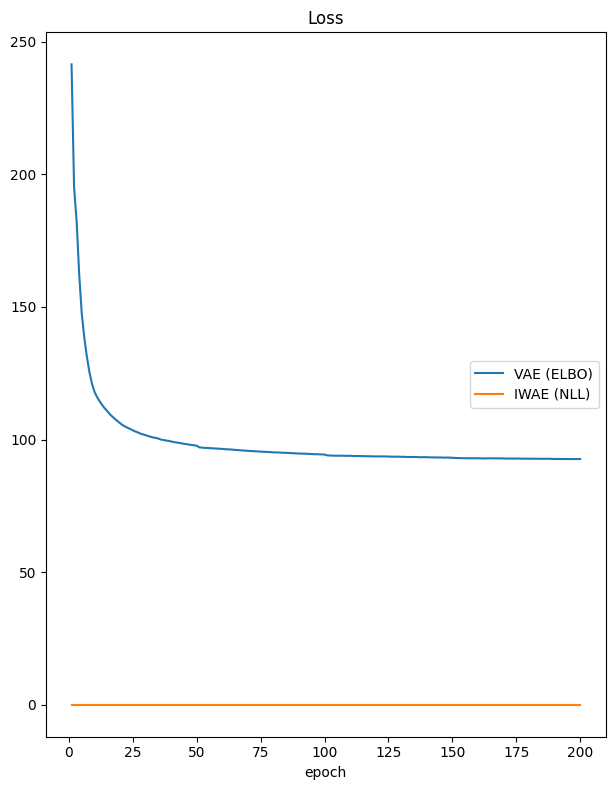

Loss
	VAE (ELBO)       	 (min:   92.631, max:  241.498, cur:   92.661)
	IWAE (NLL)       	 (min:    0.000, max:    0.000, cur:    0.000)


In [12]:


for k in list_of_ks:
    vae_model = VAE(k)
    iwae_model = IWAE(k)
    trained_vae, trained_iwae = train(binarized_MNIST, vae_model, iwae_model, num_epochs)
    torch.save(trained_vae, f'/content/drive/MyDrive/University/Masters/VAE seminar/trained_vae_{k}.pth')
    # torch.save(trained_iwae, f'./results/trained_iwae_{k}.pth')

## Results

In [14]:
def compute_test_log_likelihood(test_dataset, trained_vae, trained_iwae, k=200):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    data_loader = DataLoader(test_dataset, batch_size=20,
                             shuffle=True, num_workers=12)
    trained_vae.to(device)
    # trained_iwae.to(device)

    avg_marginal_ll_VAE = 0
    avg_marginal_ll_IWAE = 0
    for x in data_loader:
        marginal_ll, _ = trained_vae.compute_marginal_log_likelihood(x.to(device), k)
        avg_marginal_ll_VAE += marginal_ll.item() / len(data_loader)

        # marginal_ll, _ = trained_iwae.compute_marginal_log_likelihood(x.to(device), k)
        # avg_marginal_ll_IWAE += marginal_ll.item() / len(data_loader)
    return avg_marginal_ll_VAE, avg_marginal_ll_IWAE


out_table = PrettyTable(["k", "VAE", "IWAE"])
test_ds = Binarized_MNIST('./data', train=False, download=True,
                                  transform=transforms.ToTensor())
for k in list_of_ks:
    # load models
    trained_vae = torch.load(f'/content/drive/MyDrive/University/Masters/VAE seminar/trained_vae_10.pth', weights_only=False)
    # trained_iwae = torch.load(f'./results/trained_iwae_{k}.pth')
    # compute average marginal log-likelihood on test dataset
    trained_iwae = IWAE(k)
    ll_VAE, ll_IWAE = compute_test_log_likelihood(test_ds, trained_vae, trained_iwae)
    out_table.add_row([k, np.round(ll_VAE, 2), np.round(ll_IWAE, 2)])
print(out_table)

+----+--------+------+
| k  |  VAE   | IWAE |
+----+--------+------+
| 10 | -89.96 |  0   |
+----+--------+------+


In [17]:
# Load the TRAINING dataset for identification
train_dataset = Binarized_MNIST('./data', train=True, download=True,
                                transform=transforms.ToTensor())

subset_indices = range(10000)
train_subset = torch.utils.data.Subset(train_dataset, subset_indices)
analysis_loader = DataLoader(train_subset, batch_size=1000, shuffle=False)
model_path = f'/content/drive/MyDrive/University/Masters/VAE seminar/trained_vae_10.pth'
vae_model = torch.load(model_path, weights_only=False, map_location='cuda')
vae_model.eval()
all_mus = []

print("Identifying Active Units based on Training Data...")
with torch.no_grad():
    for x in analysis_loader:
        x = x.to("cuda")
        _, mu, _ = vae_model.encode(x, k=1)
        all_mus.append(mu)

all_mus = torch.cat(all_mus, dim=0)
au_statistics = torch.var(all_mus, dim=0)

threshold = 1e-2
active_units_mask = au_statistics > threshold
active_unit_indices = torch.where(active_units_mask)[0].tolist()

print(f"Active Units identified on Train set: {len(active_unit_indices)}")
print(f"Indices: {active_unit_indices}")

Identifying Active Units based on Training Data...
Active Units identified on Train set: 14
Indices: [0, 4, 7, 10, 17, 20, 26, 31, 32, 33, 38, 40, 46, 48]


In [24]:
import torch
import torch.distributions as dists
import numpy as np
from prettytable import PrettyTable

# --- Configuration ---
# Use the indices you found in the previous step
active_unit_indices = [0, 4, 7, 10, 17, 20, 26, 31, 32, 33, 38, 40, 46, 48]
k = 200  # Number of importance samples
batch_size = 100 # Smaller batch size for evaluation to save memory

# --- Helper Function: NLL with Intervention ---
def compute_nll_with_ablation(model, dataset, unit_to_zero=None, k=10):
    """
    Computes the Negative Log Likelihood (NLL) on the test set.
    If unit_to_zero is provided (int), that specific latent dimension is set to 0.
    """
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model.eval()

    total_loss = 0
    total_batches = 0

    with torch.no_grad():
        for x in data_loader:
            x = x.to(device)

            # 1. ENCODE
            # Get parameters and sample z normally
            z, mu_E, log_var_E = model.encode(x, k)

            # 2. INTERVENTION (The Test)
            # If we are testing a unit, force it to 0 (mean of the prior)
            # This breaks the link between the encoder and decoder for this dimension
            if unit_to_zero is not None:
                z[:, :, unit_to_zero] = 0.0

            # 3. DECODE
            # Decode using the modified z
            x_tilde = model.decode(z, k)

            # 4. COMPUTE LOG-LIKELIHOOD (Logic copied from compute_marginal_log_likelihood)
            # We must re-calculate manually because we modified z

            # Upsample params for broadcasting
            mu_z_s = mu_E.unsqueeze(1).repeat(1, k, 1)
            std_z_s = (0.5 * log_var_E).exp().unsqueeze(1).repeat(1, k, 1)
            x_s = x.unsqueeze(1).repeat(1, k, 1, 1, 1)

            # log p(x|z)
            log_p_x_g_z = dists.Bernoulli(x_tilde).log_prob(x_s).sum(axis=(2, 3, 4))

            # log p(z) (Prior)
            # Note: We score the *modified* z against the prior
            log_prior_z = dists.Normal(0, 1).log_prob(z).sum(2)

            # log q(z|x) (Posterior)
            # Note: We evaluate the probability of the *modified* z under the original encoder distribution
            log_q_z_g_x = dists.Normal(mu_z_s, std_z_s).log_prob(z).sum(2)

            # Combine
            log_w = log_p_x_g_z + log_prior_z - log_q_z_g_x

            # Log-Sum-Exp to get marginal likelihood estimate
            log_marginal_likelihood = (torch.logsumexp(log_w, 1) - np.log(k)).mean()

            # Accumulate NLL (Negative of likelihood)
            total_loss += -log_marginal_likelihood.item()
            total_batches += 1

    return total_loss / total_batches

# --- Run the Experiment ---
print("Running Experiment 3: Validating Active Units...")
test_dataset = Binarized_MNIST('./data', train=False, download=True,
                                  transform=transforms.ToTensor())
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# 1. Calculate Baseline (No units removed)
print("Calculating Baseline NLL...")
baseline_nll = compute_nll_with_ablation(vae_model, test_dataset, unit_to_zero=None, k=k)
print(f"Baseline Test NLL: {baseline_nll:.4f}\n")

# 2. Iterate over active units and zero them out
results = []
print(f"Testing {len(active_unit_indices)} active units...")

for idx in active_unit_indices:
    # Run ablation
    nll_ablated = compute_nll_with_ablation(vae_model, test_dataset, unit_to_zero=idx, k=k)

    # Calculate impact
    delta = nll_ablated - baseline_nll

    # Interpretation
    # If delta is small (< 0.5 nats), the unit wasn't doing much.
    status = "Fake/Noise" if delta < 0.5 else "Significant"

    results.append({
        "Unit": idx,
        "NLL": nll_ablated,
        "Delta": delta,
        "Status": status
    })

# --- Report Results ---
# Sort by Delta (impact) to see the most useless units first
results.sort(key=lambda x: x["Delta"])

table = PrettyTable()
table.field_names = ["Latent Unit Idx", "Ablated NLL", "Delta (Impact)", "Verdict"]

for res in results:
    table.add_row([
        res["Unit"],
        f"{res['NLL']:.2f}",
        f"+{res['Delta']:.3f}",
        res["Status"]
    ])

print(table)
print("\nInterpretation Guide:")
print("- Baseline NLL: Lower is better.")
print("- Delta: How much worse the model got when this unit was removed.")
print("- Low Delta (e.g., < 0.1): This unit was statistically 'active' (high variance) but semantically useless.")
print("- High Delta: This unit encodes critical information.")

Running Experiment 3: Validating Active Units...
Calculating Baseline NLL...
Baseline Test NLL: 90.0383

Testing 14 active units...
+-----------------+-------------+----------------+-------------+
| Latent Unit Idx | Ablated NLL | Delta (Impact) |   Verdict   |
+-----------------+-------------+----------------+-------------+
|        17       |    87.95    |    +-2.093     |  Fake/Noise |
|        31       |    88.55    |    +-1.485     |  Fake/Noise |
|        32       |    88.93    |    +-1.113     |  Fake/Noise |
|        7        |    89.27    |    +-0.769     |  Fake/Noise |
|        33       |    89.42    |    +-0.619     |  Fake/Noise |
|        26       |    89.46    |    +-0.575     |  Fake/Noise |
|        46       |    89.47    |    +-0.571     |  Fake/Noise |
|        0        |    89.50    |    +-0.541     |  Fake/Noise |
|        48       |    89.57    |    +-0.472     |  Fake/Noise |
|        38       |    89.93    |    +-0.112     |  Fake/Noise |
|        10       |    

Running Cumulative Re-introduction Experiment...
Total Fake Units to Evaluate: 11
Measuring NLL with 11 units removed...
-> NLL: 133.3854
Adding back Unit 31 (10 still removed)...
Adding back Unit 32 (9 still removed)...
Adding back Unit 7 (8 still removed)...
Adding back Unit 26 (7 still removed)...
Adding back Unit 0 (6 still removed)...
Adding back Unit 33 (5 still removed)...
Adding back Unit 46 (4 still removed)...
Adding back Unit 48 (3 still removed)...
Adding back Unit 38 (2 still removed)...
Adding back Unit 10 (1 still removed)...
Adding back Unit 17 (0 still removed)...

Final Results Table:
+------+-------------+----------+-------------+
| Step |    Action   |   NLL    | Improvement |
+------+-------------+----------+-------------+
|  0   | All Removed | 133.3854 |    0.0000   |
|  1   |     +31     | 122.9909 |   10.3945   |
|  2   |     +32     | 114.8785 |    8.1124   |
|  3   |      +7     | 109.5118 |    5.3667   |
|  4   |     +26     | 104.8013 |    4.7105   |
|  5  

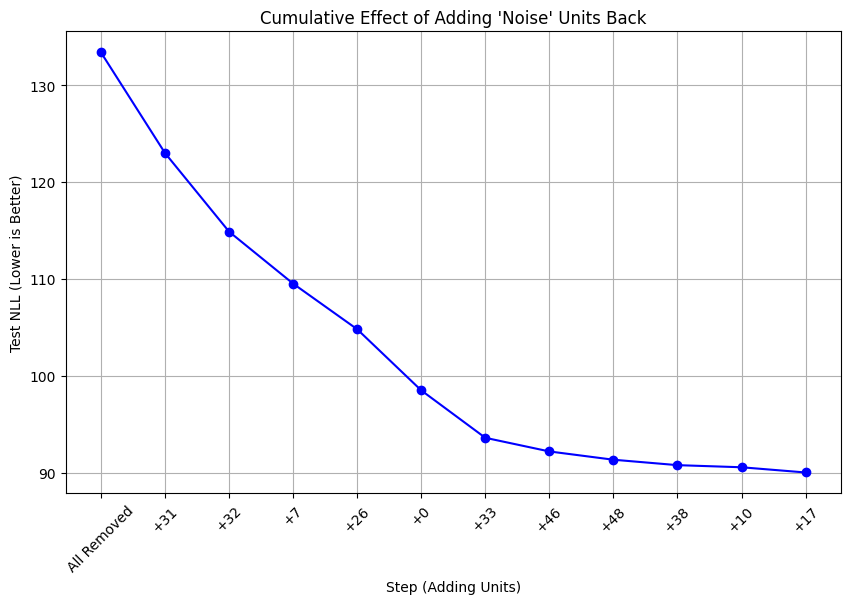

In [25]:
import matplotlib.pyplot as plt

# --- Configuration ---
# 1. Define the "Fake/Noise" units identified in your previous run (sorted by Delta)
# These are the units we will start by removing, then gradually add back.
fake_noise_units = [ 31, 32, 7, 26, 0, 33, 46, 48, 38, 10, 17]

# 2. Parameters
k = 200
batch_size = 20

# --- Helper Function: Multi-Unit Ablation ---
def compute_nll_with_multi_ablation(model, dataset, units_to_remove=[], k=200):
    """
    Computes NLL while forcing a LIST of latent units to the Prior (Mean=0, Var=1).
    """
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model.eval()

    total_loss = 0
    total_batches = 0

    with torch.no_grad():
        for x in data_loader:
            x = x.to(device)

            # 1. Get Encoder Outputs
            out_encoder = model.encoder(x)
            mu_E, log_var_E = torch.chunk(out_encoder, 2, dim=1)

            # 2. INTERVENTION: Lobotomize the specific units
            if len(units_to_remove) > 0:
                # Create a mask or index tensor
                indices = torch.tensor(units_to_remove).to(device)
                # Force mean to 0 and log_var to 0 (std=1) for these units
                mu_E.index_fill_(1, indices, 0.0)
                log_var_E.index_fill_(1, indices, 0.0)

            # 3. Standard IWAE Sampling & Evaluation
            # Upsample
            mu_E_ups = mu_E.unsqueeze(1).repeat(1, k, 1)
            log_var_E_ups = log_var_E.unsqueeze(1).repeat(1, k, 1)

            # Sample
            epsilon = torch.randn_like(log_var_E_ups)
            z = mu_E_ups + torch.exp(0.5 * log_var_E_ups) * epsilon

            # Decode
            x_tilde = model.decode(z, k)

            # Compute NLL
            mu_z_s = mu_E_ups
            std_z_s = (0.5 * log_var_E_ups).exp()
            x_s = x.unsqueeze(1).repeat(1, k, 1, 1, 1)

            log_p_x_g_z = dists.Bernoulli(x_tilde).log_prob(x_s).sum(axis=(2, 3, 4))
            log_prior_z = dists.Normal(0, 1).log_prob(z).sum(2)
            log_q_z_g_x = dists.Normal(mu_z_s, std_z_s).log_prob(z).sum(2)

            log_w = log_p_x_g_z + log_prior_z - log_q_z_g_x
            log_marginal_likelihood = (torch.logsumexp(log_w, 1) - np.log(k)).mean()

            total_loss += -log_marginal_likelihood.item()
            total_batches += 1

    return total_loss / total_batches

# --- Run the Experiment ---
print("Running Cumulative Re-introduction Experiment...")
print(f"Total Fake Units to Evaluate: {len(fake_noise_units)}")

# We start with ALL fake units removed, then pop them off one by one
current_removed = fake_noise_units.copy()
history_nll = []
history_labels = []

# Step 0: Baseline (All fake removed)
print(f"Measuring NLL with {len(current_removed)} units removed...")
nll = compute_nll_with_multi_ablation(vae_model, test_dataset, current_removed, k)
history_nll.append(nll)
history_labels.append("All Removed")
print(f"-> NLL: {nll:.4f}")

# Step Loop: Add back one by one
for i, unit_to_add in enumerate(fake_noise_units):
    # Remove the unit from the "removed" list (effectively adding it back)
    current_removed.remove(unit_to_add)

    print(f"Adding back Unit {unit_to_add} ({len(current_removed)} still removed)...")
    nll = compute_nll_with_multi_ablation(vae_model, test_dataset, current_removed, k)

    history_nll.append(nll)
    history_labels.append(f"+{unit_to_add}")

# --- Visualization ---
print("\nFinal Results Table:")
table = PrettyTable()
table.field_names = ["Step", "Action", "NLL", "Improvement"]

initial_nll = history_nll[0]
prev_nll = initial_nll

for i, (label, val) in enumerate(zip(history_labels, history_nll)):
    improvement = prev_nll - val
    table.add_row([i, label, f"{val:.4f}", f"{improvement:.4f}"])
    prev_nll = val

print(table)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(history_nll, marker='o', linestyle='-', color='b')
plt.title("Cumulative Effect of Adding 'Noise' Units Back")
plt.xlabel("Step (Adding Units)")
plt.ylabel("Test NLL (Lower is Better)")
plt.xticks(range(len(history_labels)), history_labels, rotation=45)
plt.grid(True)
plt.show()